In [6]:
# importing libraries and packages

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='white')
from PIL import Image

import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

In [7]:
# load the dataset and show the first 5 rows
df = pd.read_csv('Sentiment Analysis on Student Feedback999.csv')
df.head()

,Timestamp,Course Code,Feedback,Gender,Attendance,Course Difficulty,Study Hours (per week),Overall Satisfaction,Department,Unnamed: 11
0,2023/05/21 3:29:49 AM MDT,CPE 321,"The man is too fast in his teaching,he clearly...",Male,Regular,Challenging,21,5,Yes,20/30GR072
1,2023/05/21 3:39:59 AM MDT,CPE 331,The class is dry but he really puts in efforts,Male,Regular,Moderate,7,8,Yes,19/30GR010
2,2023/05/21 3:57:54 AM MDT,CPE 321,The course is shit and it's a threat to my bra...,Male,Regular,Challenging,7,4,Yes,20/30GR073
3,2023/05/21 4:52:08 AM MDT,CPE 321,"He no try at all, didn't teach well.",Male,Regular,Challenging,12,1,Yes,NaN
4,2023/05/21 5:24:33 AM MDT,CPE 321,Ogbeni you sef know as e dae go,Male,Occasional,Difficult,8,0,Yes,NaN


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Timestamp               100 non-null    object
 1   Course Code             100 non-null    object
 2   Feedback                100 non-null    object
 3   Gender                  100 non-null    object
 4   Attendance              100 non-null    object
 5   Course Difficulty       100 non-null    object
 6   Study Hours (per week)  100 non-null    object
 7   Overall Satisfaction    100 non-null    int64 
 8   Department              100 non-null    object
 9   Unnamed: 11             3 non-null      object
dtypes: int64(1), object(9)
memory usage: 7.9+ KB


In [9]:
# drop unncessary column
df = df.drop(['Unnamed: 11'], axis=1)

# Convert the column to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extract the date and time into separate columns
df['Date'] = df['Timestamp'].dt.date
df['Time'] = df['Timestamp'].dt.time

# drop Timestamp column
df = df.drop(['Timestamp'], axis=1)

# corrections to "Study Hours (per week) column"
df['Study Hours (per week)'] = df['Study Hours (per week)'].str.extract(r'(\d+)').fillna(0).astype(int)

In [10]:
# Function to handle contractions
def handle_contractions(text):
    contractions = {
        "n't": " not",
        "'s": " is",
        "'re": " are",
        "'ve": " have",
        "'d": " would",
        "'ll": " will",
        "'m": " am"
    }

    words = text.split()
    for i in range(len(words)):
        if words[i] in contractions:
            words[i] = contractions[words[i]]
    return ' '.join(words)

# Function to preprocess text data
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs, hashtags, mentions, and special characters
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)

    # Remove numbers/digits
    text = re.sub(r'\b[0-9]+\b\s*', '', text)
#     text = re.sub(r'\d+', '', text)

    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Convert to lowercase
    tokens = [token.lower() for token in tokens]

    # Handle contractions
    text = handle_contractions(' '.join(tokens))

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in word_tokenize(text)]

    # Join tokens back into a single string
    processed_text = ' '.join(tokens)

    return processed_text

# Apply preprocessing to the 'Feedback' column
df['Processed_Feedback'] = df['Feedback'].apply(preprocess_text)

In [11]:
from langdetect import detect

def detect_language(text):
    try:
        lang = detect(text)
        return lang
    except:
        return None
    
df['Language'] = df['Processed_Feedback'].apply(detect_language)
df['Language'].unique()

array(['en', 'cy', 'so', 'sk', 'af', 'fr', 'hr', 'id', 'pt', 'pl', 'es'],
      dtype=object)

In [12]:
pip install langdetect


Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
language_mapping = {
    'en': 'English',
    'cy': 'Welsh',
    'so': 'Somali',
    'sk': 'Slovak',
    'af': 'Afrikaans',
    'fr': 'French',
    'hr': 'Croatian',
    'id': 'Indonesian',
    'pt': 'Portuguese',
    'it': 'Italian',
    'pl': 'Polish',
    'es': 'Spanish'
}

df['Language'] = df['Language'].map(language_mapping)
df['Language'].unique()

array(['English', 'Welsh', 'Somali', 'Slovak', 'Afrikaans', 'French',
       'Croatian', 'Indonesian', 'Portuguese', 'Polish', 'Spanish'],
      dtype=object)

In [14]:
df

,Course Code,Feedback,Gender,Attendance,Course Difficulty,Study Hours (per week),Overall Satisfaction,Department,Date,Time,Processed_Feedback,Language
0,CPE 321,"The man is too fast in his teaching,he clearly...",Male,Regular,Challenging,21,5,Yes,2023-05-21,03:29:49,man fast teachinghe clearly doesnt know teach ...,English
1,CPE 331,The class is dry but he really puts in efforts,Male,Regular,Moderate,7,8,Yes,2023-05-21,03:39:59,class dry really put effort,English
2,CPE 321,The course is shit and it's a threat to my bra...,Male,Regular,Challenging,7,4,Yes,2023-05-21,03:57:54,course shit threat brainthe teaching mode poor,English
3,CPE 321,"He no try at all, didn't teach well.",Male,Regular,Challenging,12,1,Yes,2023-05-21,04:52:08,try didnt teach well,English
4,CPE 321,Ogbeni you sef know as e dae go,Male,Occasional,Difficult,8,0,Yes,2023-05-21,05:24:33,ogbeni sef know e dae go,Welsh
...,...,...,...,...,...,...,...,...,...,...,...,...
95,GSE 301,easy and no wahala,Female,Regular,Easy,9,8,Yes,2023-05-30,14:56:07,easy wahala,Somali
96,CPE 321,terrible way of teaching with the I-dont-care ...,Female,Irregular,Difficult,4,0,Yes,2023-05-30,14:57:17,terrible way teaching idontcare attitude,English
97,CPE 341,do not like coding,Male,Irregular,Difficult,0,0,Yes,2023-05-30,15:02:16,like coding,Croatian
98,CPE 381,this practical is hard on top 1 unit course haba,Female,Regular,Difficult,5,0,Yes,2023-05-30,15:03:39,practical hard top unit course haba,English


In [15]:
df['Char_Count'] = df['Processed_Feedback'].apply(len) # can also use df['Processed_Feedback'].str.len()
df['Word_Count'] = df['Processed_Feedback'].apply(lambda x: len(x.split()))
df = df.drop(['Language'], axis=1)

In [16]:
# Calculate sentiment scores
df['Sentiment_Score'] = df['Processed_Feedback'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Calculate subjectivity scores
df['Subjectivity_Score'] = df['Processed_Feedback'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Map sentiment scores to sentiment labels
df['Sentiment_Label'] = df.apply(lambda row: 'Positive' if row['Sentiment_Score'] > 0 and row['Subjectivity_Score'] > 0.5 else 
                                        'Negative' if row['Sentiment_Score'] < 0 and row['Subjectivity_Score'] > 0.5 else 'Neutral', axis=1)

In [17]:
df.sample(5)

,Course Code,Feedback,Gender,Attendance,Course Difficulty,Study Hours (per week),Overall Satisfaction,Department,Date,Time,Processed_Feedback,Char_Count,Word_Count,Sentiment_Score,Subjectivity_Score,Sentiment_Label
65,CPE 381,"I learnt a lot in the course, but the lecturer...",Female,Regular,Moderate,3,5,Yes,2023-05-30,14:17:19,learnt lot course lecturer demanding,36,5,0.000000,0.0,Neutral
39,CPE 381,why is a 1 unit course stressing our lives?,Female,Irregular,Challenging,1,1,Yes,2023-05-29,15:36:57,unit course stressing life,26,4,0.000000,0.0,Neutral
94,CPE 311,nice course,Male,Regular,Easy,10,9,Yes,2023-05-30,14:55:21,nice course,11,2,0.600000,1.0,Positive
16,CPE 321,The lecturer is fucking terrible. With his I-d...,Male,Regular,Difficult,7,0,Yes,2023-05-24,09:27:51,lecturer fucking terrible idontcare attitude t...,79,10,-0.633333,1.0,Negative
89,CPE 331,awesome,Female,Regular,Easy,12,9,Yes,2023-05-30,14:49:48,awesome,7,1,1.000000,1.0,Positive


In [18]:
# Sentiment Analysis Metrics
sentiment_counts = df['Sentiment_Label'].value_counts()
average_sentiment_score = df['Sentiment_Score'].mean()
average_subj_score = df['Subjectivity_Score'].mean()

# Descriptive Statistics
study_hours_stats = df['Study Hours (per week)'].describe()
overall_satisfaction_stats = df['Overall Satisfaction'].describe()

# Categorical Metrics
course_code_counts = df['Course Code'].value_counts()
department_counts = df['Department'].value_counts()
sentiment_distribution = df.groupby('Course Code')['Sentiment_Label'].value_counts(normalize=True)

# Print the calculated metrics
print("Sentiment Analysis Metrics:")
print(sentiment_counts)
print("Average Sentiment Score:", average_sentiment_score)
print("Average SUbjectivity Score:", average_subj_score)
print("\nDescriptive Statistics - Study Hours:")
print(study_hours_stats)
print("\nDescriptive Statistics - Overall Satisfaction:")
print(overall_satisfaction_stats)
print("\nCategorical Metrics - Course Code Counts:")
print(course_code_counts)
print("\nCategorical Metrics - Department Counts:")
print(department_counts)
print("\nSentiment Distribution by Course Code:")
print(sentiment_distribution)

Sentiment Analysis Metrics:
Sentiment_Label
Neutral     42
Positive    34
Negative    24
Name: count, dtype: int64
Average Sentiment Score: 0.04988879870129869
Average SUbjectivity Score: 0.5088712121212121

Descriptive Statistics - Study Hours:
count    100.000000
mean       8.440000
std        5.386703
min        0.000000
25%        4.000000
50%        8.000000
75%       12.000000
max       21.000000
Name: Study Hours (per week), dtype: float64

Descriptive Statistics - Overall Satisfaction:
count    100.000000
mean       5.100000
std        3.599944
min        0.000000
25%        1.000000
50%        5.000000
75%        9.000000
max       10.000000
Name: Overall Satisfaction, dtype: float64

Categorical Metrics - Course Code Counts:
Course Code
CPE 321    31
CPE 311    13
CPE 341    13
CPE 381    12
CPE 331    11
MEE 361    10
GSE 301    10
Name: count, dtype: int64

Categorical Metrics - Department Counts:
Department
Yes    99
No      1
Name: count, dtype: int64

Sentiment Distribut

In [26]:
# analyze the frequency of specific keywords or phrases in the feedback
from collections import Counter

# The keywords or phrases of interest
keywords = ['shit', 'difficult', 'terrible', 'okay', 'best', 'worst', 'good', 'try']

# Concatenate all the preprocessed feedback into a single string
all_feedback = ' '.join(df['Processed_Feedback'])

# Tokenize the text into individual words
tokens = all_feedback.split()

# Count the frequency of each keyword in the feedback
keyword_frequency = Counter(tokens)

# Print the frequency of each keyword
for keyword in keywords:
    print(f"Frequency of '{keyword}': {keyword_frequency[keyword]}")

Frequency of 'shit': 1
Frequency of 'difficult': 4
Frequency of 'terrible': 5
Frequency of 'okay': 3
Frequency of 'best': 3
Frequency of 'worst': 2
Frequency of 'good': 8
Frequency of 'try': 1


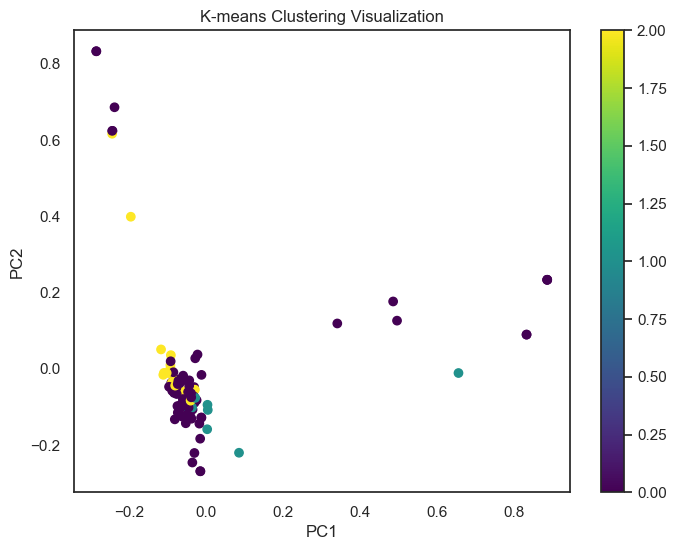

Top terms per cluster:
Cluster 0:
   course
   nice
   lecturer
   good
   teaching
   awful
   stress
   method
   hard
   terrible
Cluster 1:
   easy
   course
   wahala
   relatively
   nice
   got
   hell
   struggled
   went
   sometimes
Cluster 2:
   like
   god
   class
   lecturer
   student
   make
   dry
   coding
   sha
   good


In [27]:
# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Apply TF-IDF vectorization to the processed feedback text
tfidf_matrix = vectorizer.fit_transform(df['Processed_Feedback'])

# Perform K-means clustering
num_clusters = 3  # Specify the desired number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

# Assign cluster labels to the feedback data
df['Cluster'] = kmeans.labels_

# Apply dimensionality reduction using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(tfidf_matrix.toarray())

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=df['Cluster'], cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-means Clustering Visualization')
plt.colorbar()
plt.show()
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(num_clusters):
    print(f"Cluster {i}:")
    for ind in order_centroids[i, :10]:
        print(f"   {terms[ind]}")


In [28]:
# Create a CountVectorizer
vectorizer = CountVectorizer(max_features=1000, lowercase=True, stop_words='english', ngram_range=(1, 2))

# Apply CountVectorizer to the processed feedback text
dtm = vectorizer.fit_transform(df['Processed_Feedback'])

# Perform LDA topic modeling
num_topics = 10  # Specify the desired number of topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)

# Get the top words for each topic and visualize
feature_names = vectorizer.get_feature_names_out()  # Corrected
top_words = 10  # Specify the number of top words to retrieve for each topic
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx}:")
    top_feature_indices = topic.argsort()[:-top_words - 1:-1]
    for i in top_feature_indices:
        print(f"   {feature_names[i]}")


Topic 0:
   course
   lecturer
   difficult lecturer
   difficult
   hard
   time
   isnt
   teaching
   course difficult
   man
Topic 1:
   course
   good
   lecturer
   nice
   terrible
   nice course
   easy course
   easy
   awful
   lecturer good
Topic 2:
   course
   nice
   teaching
   lecturer
   method
   teaching method
   stress
   method lecturer
   nice teaching
   cool
Topic 3:
   teaching
   code
   terrible
   course
   method
   teaching method
   bad
   love
   love code
   course taught
Topic 4:
   time
   bad
   okay
   teaching
   teaching mode
   mode
   taught
   lecturer
   revision
   revision whats
Topic 5:
   course
   make
   class
   dey
   especially
   dey make
   experience
   easy
   man
   pas
Topic 6:
   akanni
   cool
   way
   god
   teach
   know
   really
   dry
   class dry
   know teach
Topic 7:
   course
   easy
   awful
   wahala
   course hard
   hard
   good
   lecturer
   unit course
   unit
Topic 8:
   lecturer
   course
   class
   course

In [29]:
def calculate_emotions(text):
    blob = TextBlob(text)
    emotion_scores = blob.sentiment.polarity, blob.sentiment.subjectivity
    return emotion_scores

# Apply emotion analysis to the feedback text
df['Emotion_Scores'] = df['Processed_Feedback'].apply(calculate_emotions)

# Extract emotion scores for each emotion category
df['Emotion_Polarity'] = df['Emotion_Scores'].apply(lambda x: x[0])

# assign emotion labels based on polarity values
df['Emotion_Label'] = df['Emotion_Polarity'].apply(lambda x: 'Positive' if x > 0 else 'Negative' if x < 0 else 'Neutral')

# the resulting dataframe with emotion scores and labels
df[['Processed_Feedback', 'Emotion_Polarity', 'Emotion_Label']].head()

,Processed_Feedback,Emotion_Polarity,Emotion_Label
0,man fast teachinghe clearly doesnt know teach ...,0.150000,Positive
1,class dry really put effort,0.066667,Positive
2,course shit threat brainthe teaching mode poor,-0.300000,Negative
3,try didnt teach well,0.000000,Neutral
4,ogbeni sef know e dae go,0.000000,Neutral


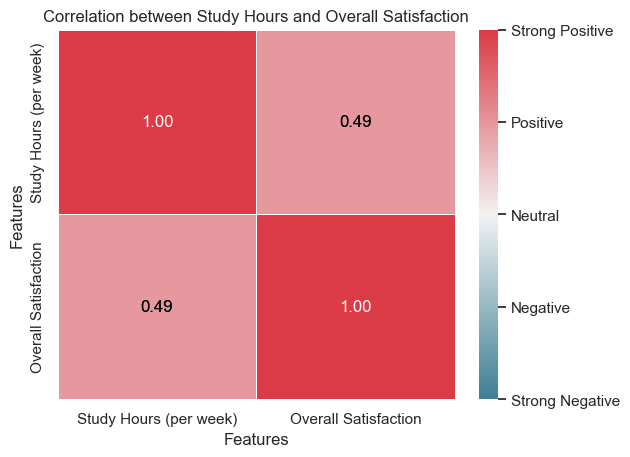

In [30]:
correlation_matrix = df[['Study Hours (per week)', 'Overall Satisfaction']].corr()

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=cmap, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation between Study Hours and Overall Satisfaction')

for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if i != j:
            text = '{:.2f}'.format(correlation_matrix.iloc[i, j])
            plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black')

colorbar = plt.gca().collections[0].colorbar
colorbar.set_ticks([-1, -0.5, 0, 0.5, 1])
colorbar.set_ticklabels(['Strong Negative', 'Negative', 'Neutral', 'Positive', 'Strong Positive'])

plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

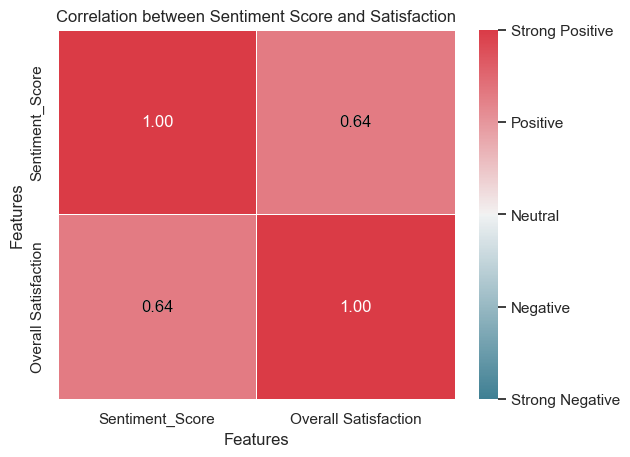

In [31]:
correlation_matrix = df[['Sentiment_Score', 'Overall Satisfaction']].corr()

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=cmap, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation between Sentiment Score and Satisfaction')

for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if i != j:
            text = '{:.2f}'.format(correlation_matrix.iloc[i, j])
            plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black')

colorbar = plt.gca().collections[0].colorbar
colorbar.set_ticks([-1, -0.5, 0, 0.5, 1])
colorbar.set_ticklabels(['Strong Negative', 'Negative', 'Neutral', 'Positive', 'Strong Positive'])

plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

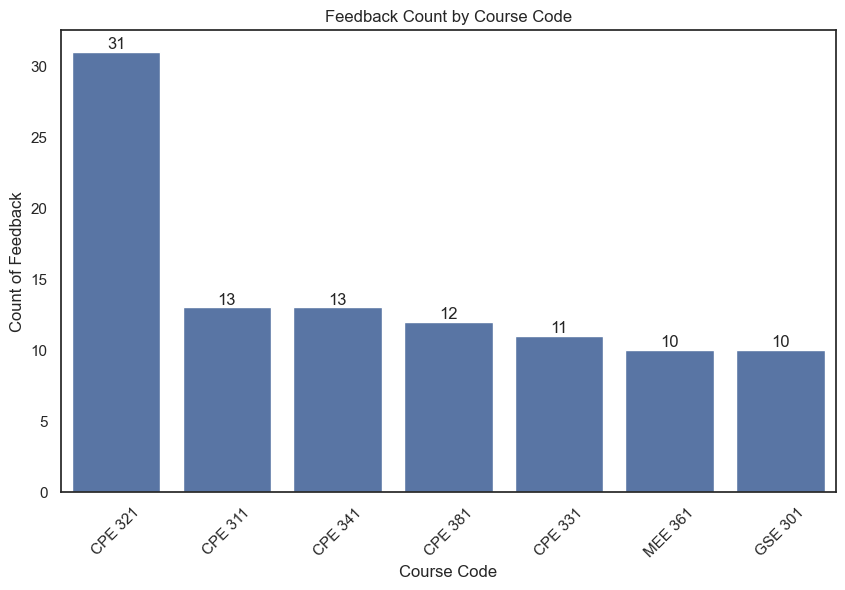

In [32]:
# Bar plot for Course Code
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
order = df['Course Code'].value_counts().index
ax = sns.countplot(data=df, x='Course Code', color=color, order=order)
plt.xlabel('Course Code')
plt.ylabel('Count of Feedback')
plt.title('Feedback Count by Course Code')
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')
plt.show()

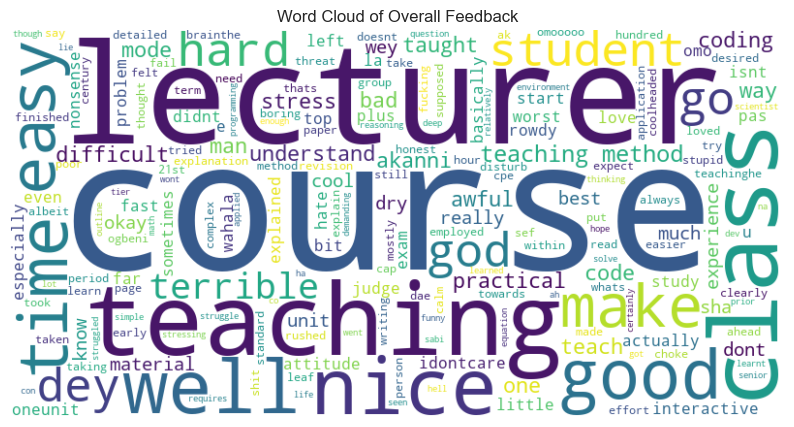

In [33]:
# Word cloud for Overall Feedback: Combine all feedback into a single string
all_feedback = ' '.join(df['Processed_Feedback'])

plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_feedback)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Overall Feedback')
plt.show()

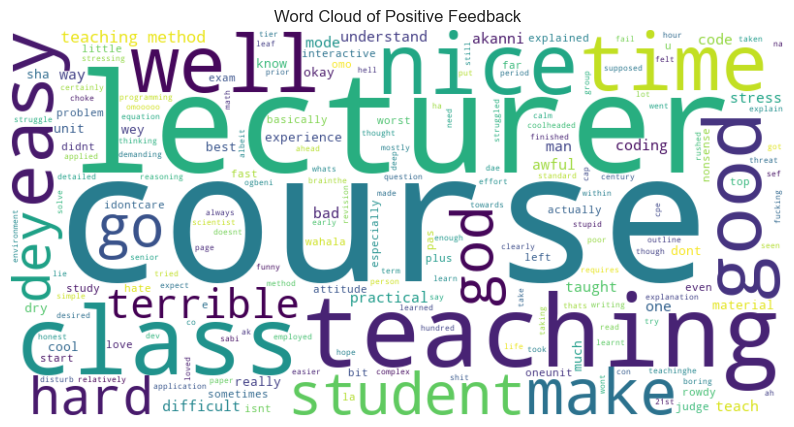

In [34]:
# Word cloud for Positive Feedback
data = ' '.join(df[df['Processed_Feedback'] == 'Positive']['Processed_Feedback'])

plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_feedback)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive Feedback')
plt.show()

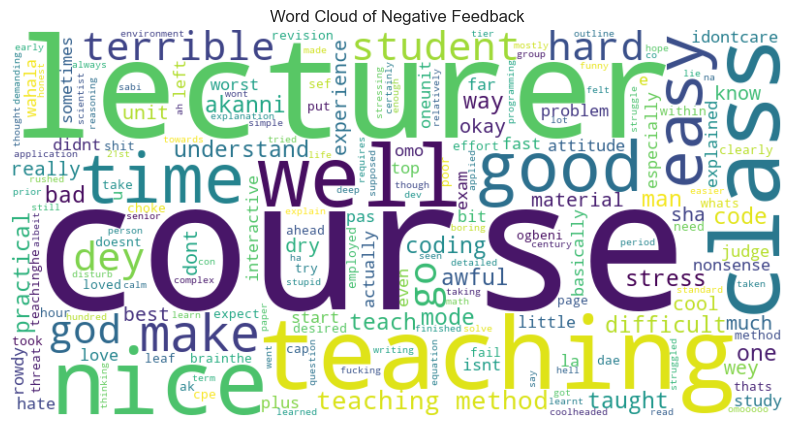

In [35]:
# Word cloud for Negative Feedback
data = ' '.join(df[df['Processed_Feedback'] == 'Negative']['Processed_Feedback'])

plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_feedback)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Negative Feedback')
plt.show()

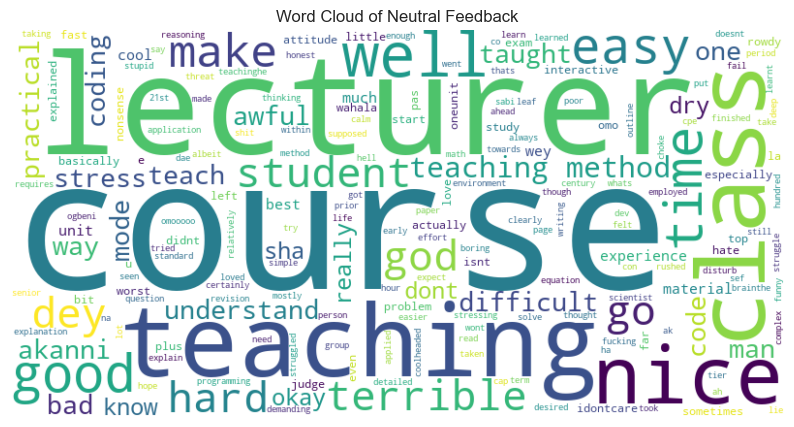

In [36]:
# Word cloud for Neutral Feedback
data = ' '.join(df[df['Processed_Feedback'] == 'Neutral']['Processed_Feedback'])

plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_feedback)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Neutral Feedback')
plt.show()

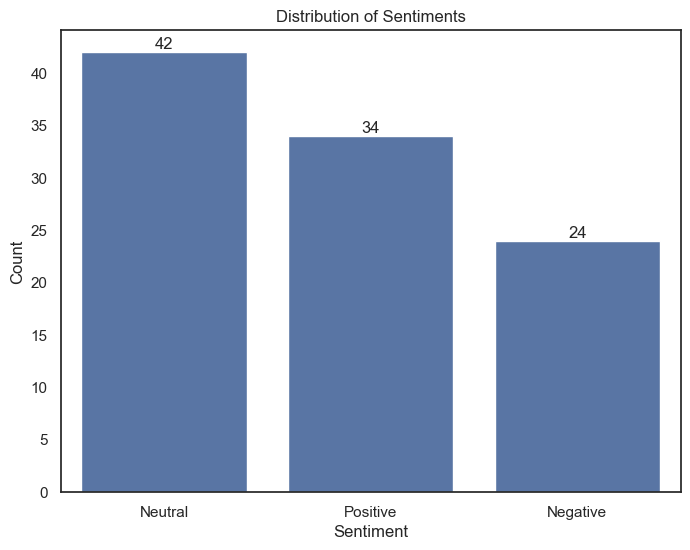

In [37]:
# Bar plot for Sentiment
plt.figure(figsize=(8, 6))
color = sns.color_palette()[0]
order = df['Sentiment_Label'].value_counts().index
ax = sns.countplot(data=df, x='Sentiment_Label', color=color, order=order)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')
plt.show()

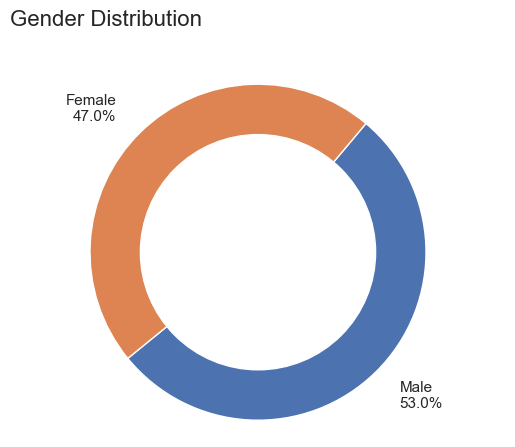

In [39]:
# Pie chart for Gender distribution
counts = df['Gender'].value_counts()
labels = [f"{gender}\n{count / len(df) * 100:.1f}%" for gender, count in counts.items()]

fig, ax = plt.subplots()
ax.pie(counts, labels=labels, startangle=50, counterclock=False, pctdistance=0.8, labeldistance=1.2)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)
ax.set_title('Gender Distribution', fontsize=16, loc='left', pad=30)
ax.axis('equal')
plt.show()

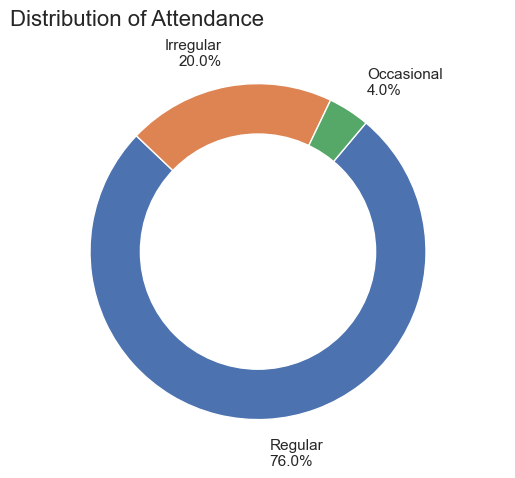

In [40]:
# Pie chart for Attendance
counts = df['Attendance'].value_counts()
labels = [f"{attendance}\n{count / len(df) * 100:.1f}%" for attendance, count in counts.items()]

fig, ax = plt.subplots()
ax.pie(counts, labels=labels, startangle=50, counterclock=False, pctdistance=0.8, labeldistance=1.2)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)
ax.set_title('Distribution of Attendance', fontsize=16, loc='left', pad=30)
ax.axis('equal')
plt.show()

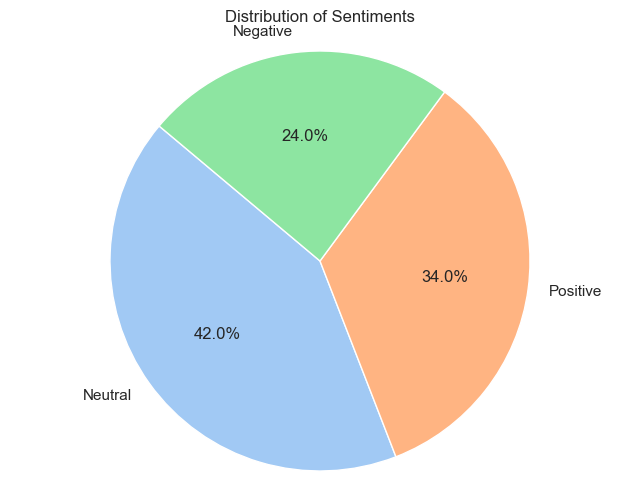

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate counts for each sentiment category
sentiment_counts = df['Sentiment_Label'].value_counts()

plt.figure(figsize=(8, 6))
colors = sns.color_palette('pastel')[0:len(sentiment_counts)]  # Set colors for the pie chart
plt.pie(sentiment_counts, labels=sentiment_counts.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sentiments')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


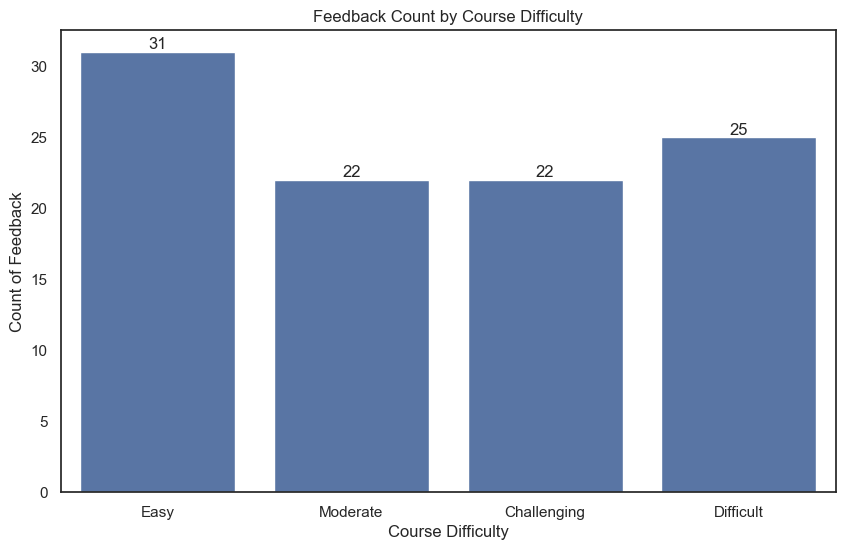

In [42]:
# Bar plot for Course Difficulty
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
order = ['Easy', 'Moderate', 'Challenging', 'Difficult']
ax = sns.countplot(data=df, x='Course Difficulty', color=color, order=order)
plt.xlabel('Course Difficulty')
plt.ylabel('Count of Feedback')
plt.title('Feedback Count by Course Difficulty')
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')
plt.show();

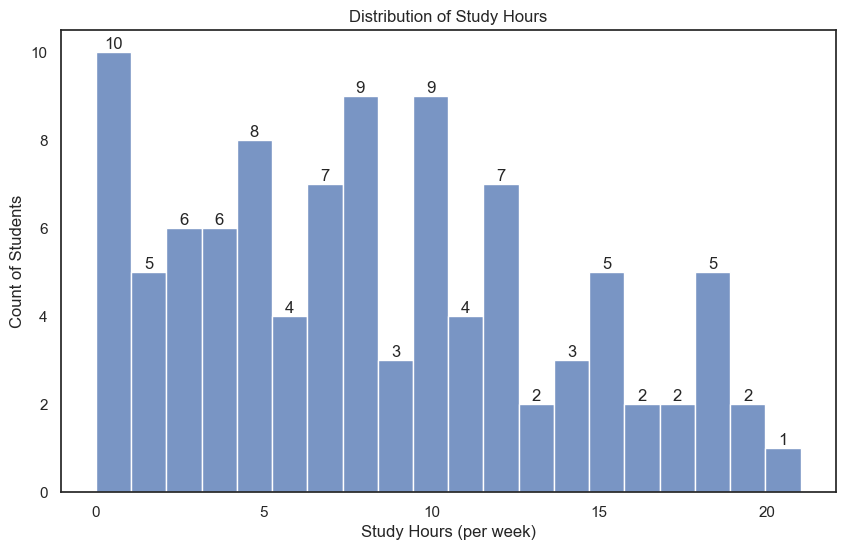

In [43]:
# Histogram for Study Hours (per week)
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
ax = sns.histplot(data=df, x='Study Hours (per week)', bins=20, color=color)
plt.xlabel('Study Hours (per week)')
plt.ylabel('Count of Students')
plt.title('Distribution of Study Hours')
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')
plt.show()

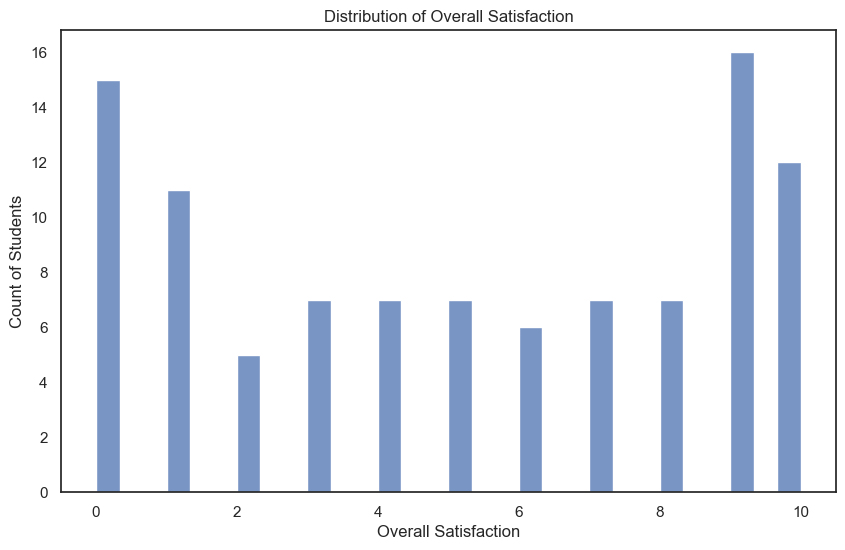

In [44]:
# Histogram for Overall Satisfaction
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Overall Satisfaction', bins=30)
plt.xlabel('Overall Satisfaction')
plt.ylabel('Count of Students')
plt.title('Distribution of Overall Satisfaction')
plt.show()

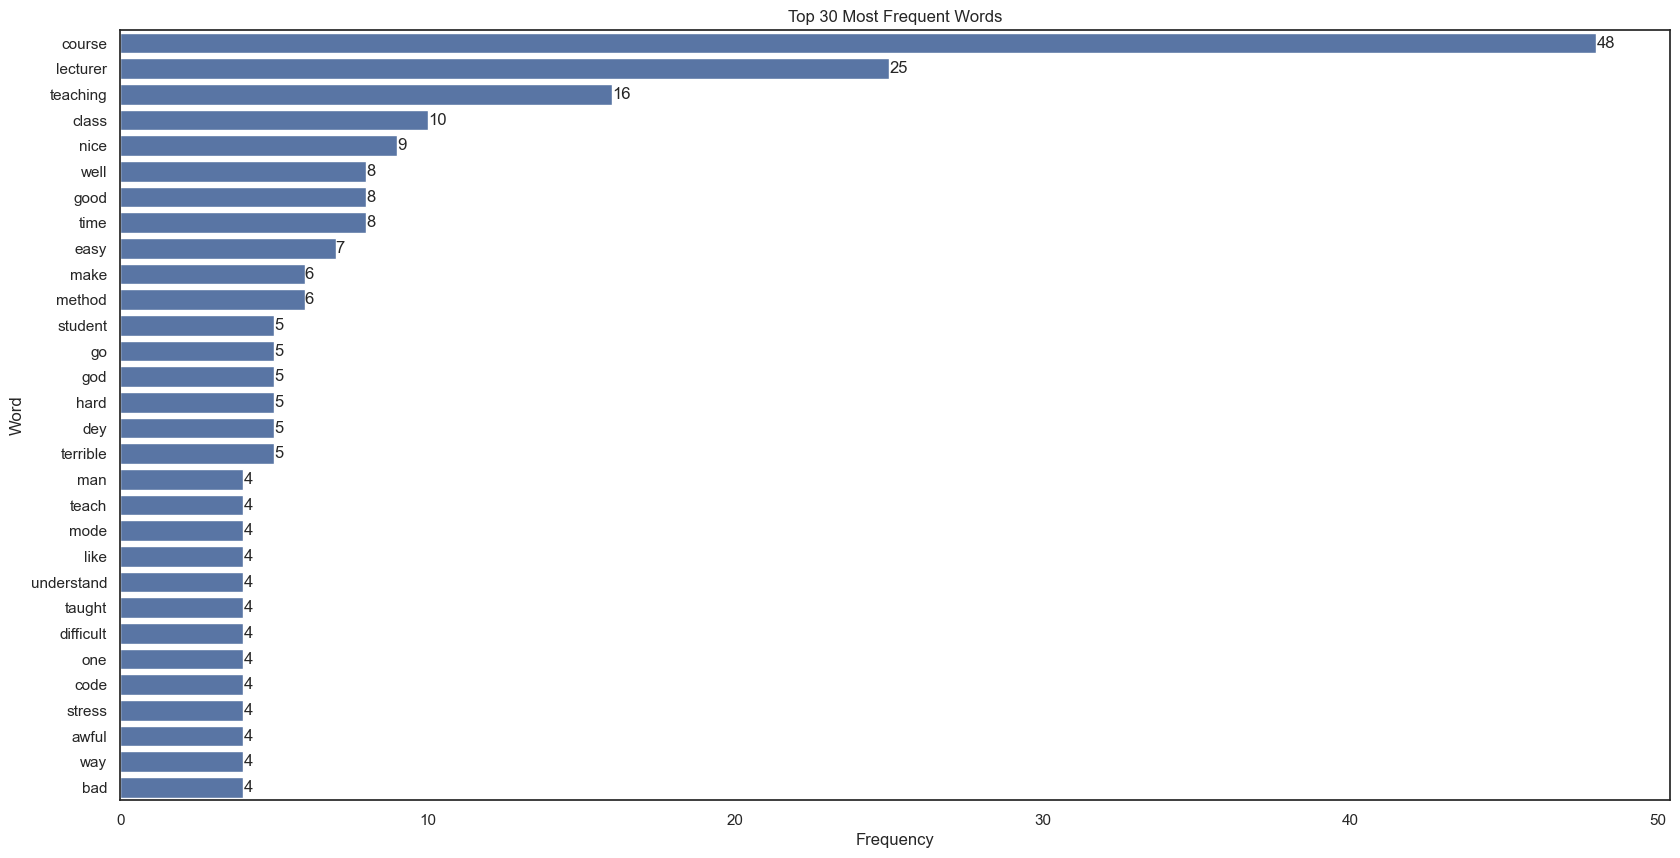

In [45]:
# Word Frequency Analysis
from collections import Counter
word_frequency = Counter(" ".join(df['Processed_Feedback']).split()).most_common(30)
plt.figure(figsize=(20, 10))
color = sns.color_palette()[0]
ax = sns.barplot(x=[word[1] for word in word_frequency], y=[word[0] for word in word_frequency], color=color)
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Top 30 Most Frequent Words')
plt.show()

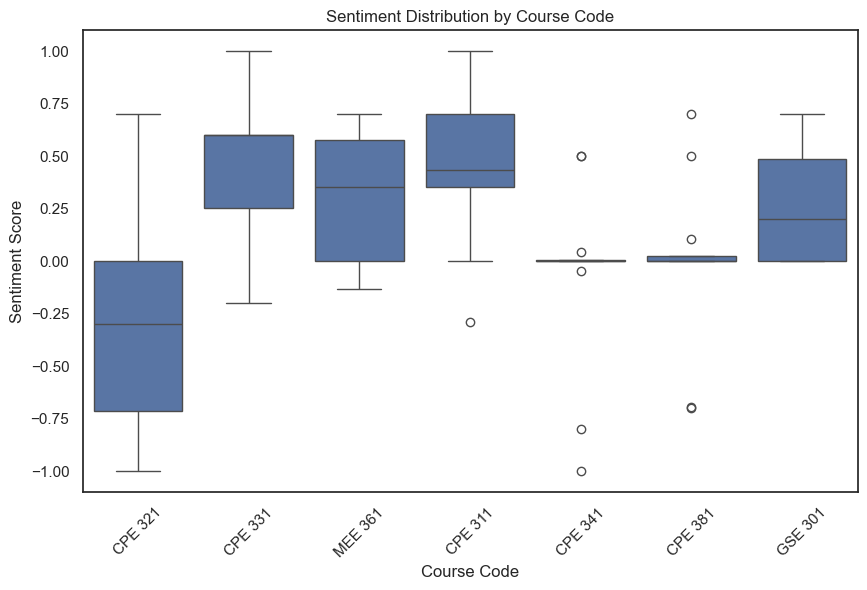

In [46]:
# Sentiment Box Plots
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
sns.boxplot(data=df, x='Course Code', y='Sentiment_Score', color=color)
plt.xlabel('Course Code')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Distribution by Course Code')
plt.xticks(rotation=45)
plt.show()

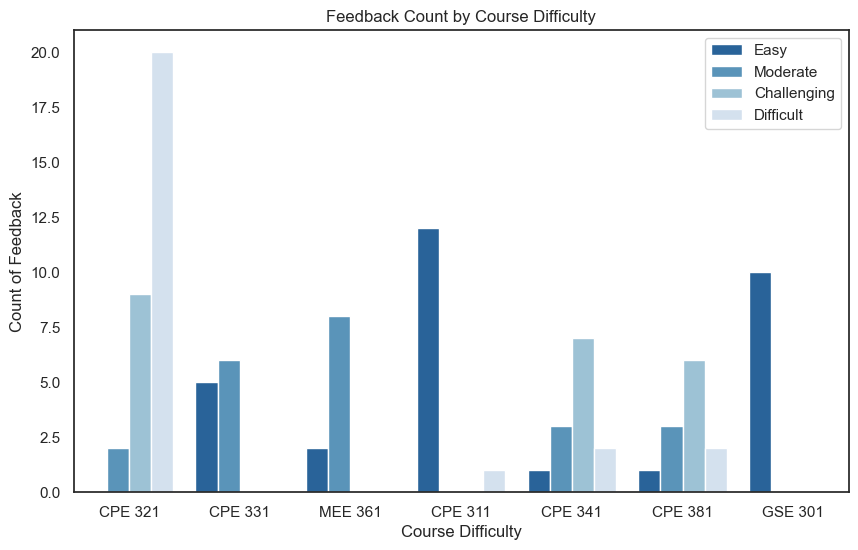

In [47]:
# Bar plot for Course Difficulty
plt.figure(figsize=(10, 6))
hue_order = ['Easy', 'Moderate', 'Challenging', 'Difficult']
sns.countplot(data=df, x='Course Code', hue='Course Difficulty', palette='Blues_r', hue_order=hue_order)
plt.xlabel('Course Difficulty')
plt.ylabel('Count of Feedback')
plt.title('Feedback Count by Course Difficulty')
plt.legend(loc=1)
plt.show();

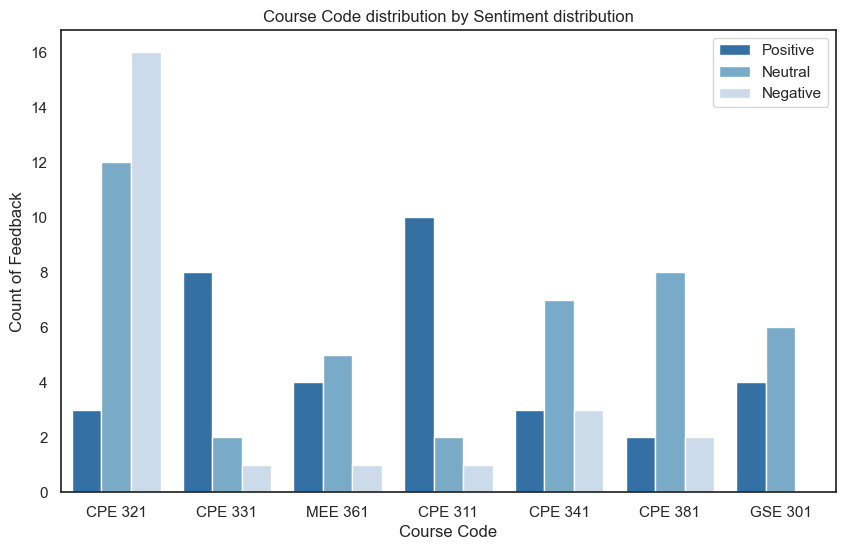

In [48]:
# Bar plot for Course Code distribution by Sentiment distribution
plt.figure(figsize=(10, 6))
hue_order = ['Positive', 'Neutral', 'Negative']
sns.countplot(data=df, x='Course Code', hue='Sentiment_Label', palette='Blues_r', hue_order=hue_order)
plt.xlabel('Course Code')
plt.ylabel('Count of Feedback')
plt.title('Course Code distribution by Sentiment distribution')
plt.legend(loc=1)
plt.show();

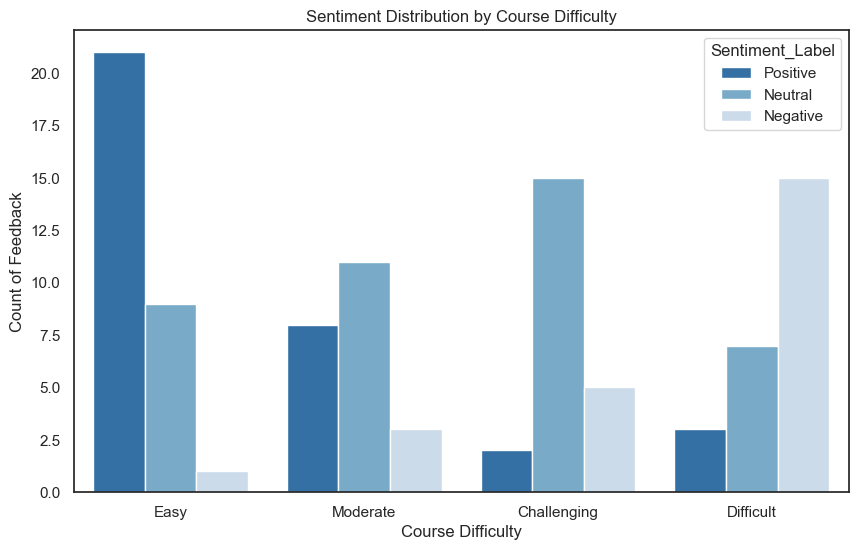

In [49]:
# Sentiment Distribution by Course Difficulty
plt.figure(figsize=(10, 6))
hue_order = ['Positive', 'Neutral', 'Negative']
order = ['Easy', 'Moderate', 'Challenging', 'Difficult']
sns.countplot(data=df, x='Course Difficulty', hue='Sentiment_Label', 
              palette='Blues_r', hue_order=hue_order, order=order)
plt.xlabel('Course Difficulty')
plt.ylabel('Count of Feedback')
plt.title('Sentiment Distribution by Course Difficulty')
plt.show()

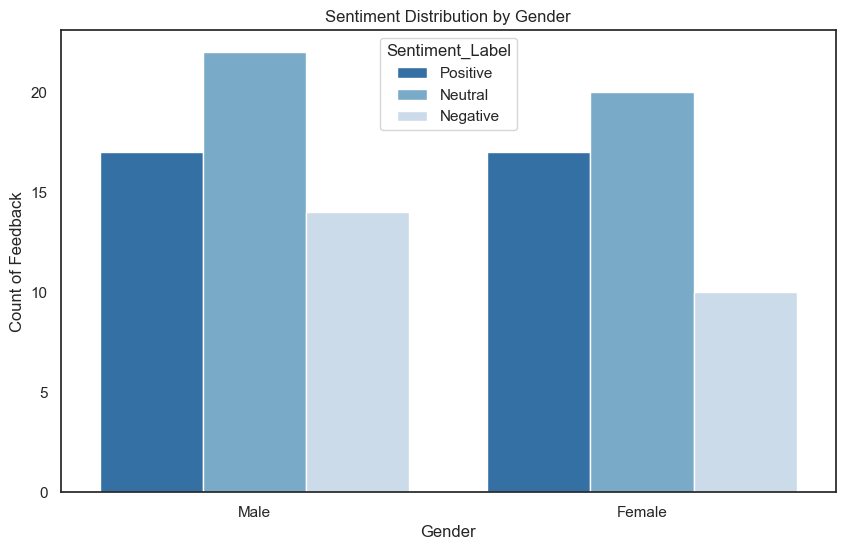

In [50]:
# Sentiment Distribution by Gender
plt.figure(figsize=(10, 6))
hue_order = ['Positive', 'Neutral', 'Negative']
sns.countplot(data=df, x='Gender', hue='Sentiment_Label', hue_order=hue_order, palette='Blues_r')
plt.xlabel('Gender')
plt.ylabel('Count of Feedback')
plt.title('Sentiment Distribution by Gender')
plt.show()

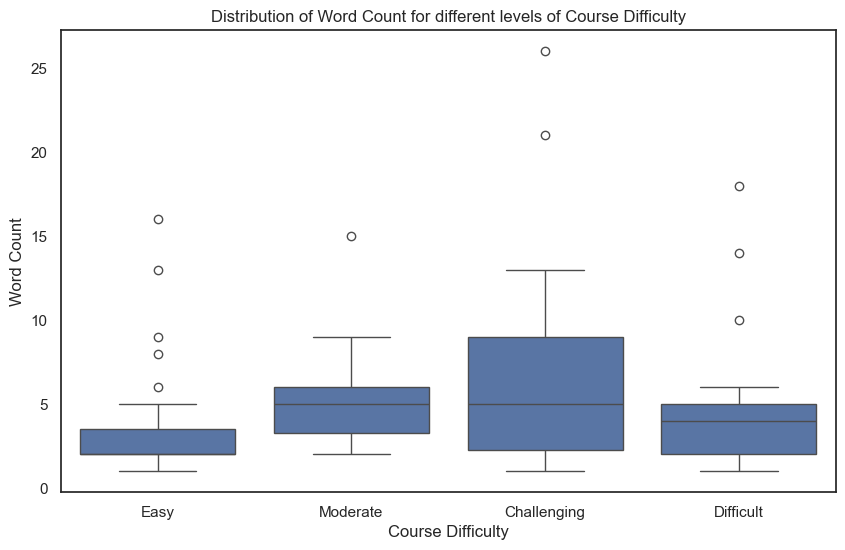

In [51]:
# Word Count distribution by course difficulty
plt.figure(figsize=(10, 6))
order = ['Easy', 'Moderate', 'Challenging', 'Difficult']
color = sns.color_palette()[0]
sns.boxplot(data=df, x='Course Difficulty', y='Word_Count', color=color, order=order)
plt.xlabel('Course Difficulty')
plt.ylabel('Word Count')
plt.title('Distribution of Word Count for different levels of Course Difficulty')
plt.show()

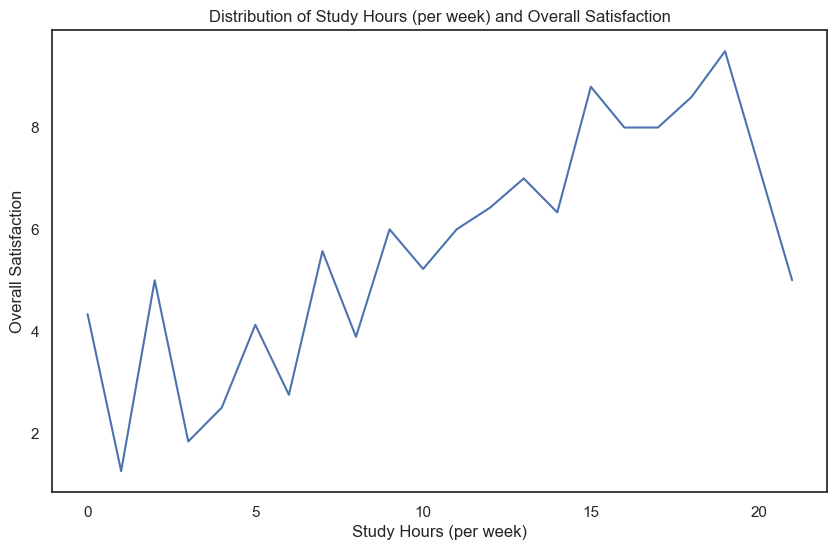

In [52]:
# Distribution of Study Hours (per week) and Overall Satisfaction
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
sns.lineplot(data=df, x='Study Hours (per week)', y='Overall Satisfaction', color=color, ci=None)
plt.xlabel('Study Hours (per week)')
plt.ylabel('Overall Satisfaction')
plt.title('Distribution of Study Hours (per week) and Overall Satisfaction')
plt.show()

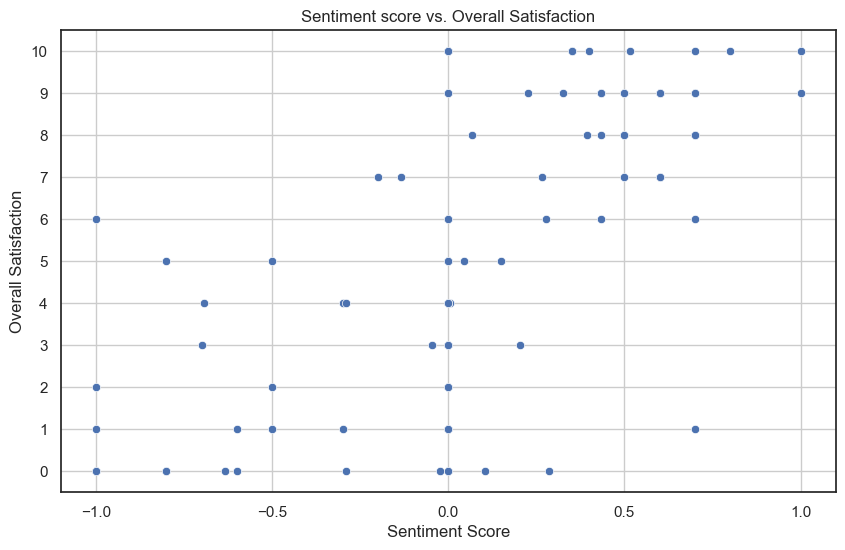

In [53]:
# Sentiment vs. Overall Satisfaction
import numpy as np  
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
sns.scatterplot(x='Sentiment_Score', y='Overall Satisfaction', data=df, color=color)
plt.xlabel('Sentiment Score')
plt.ylabel('Overall Satisfaction')
plt.title('Sentiment score vs. Overall Satisfaction')
plt.xticks(np.arange(-1, 1.1, 0.5))
plt.yticks(np.arange(0, 11))
plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

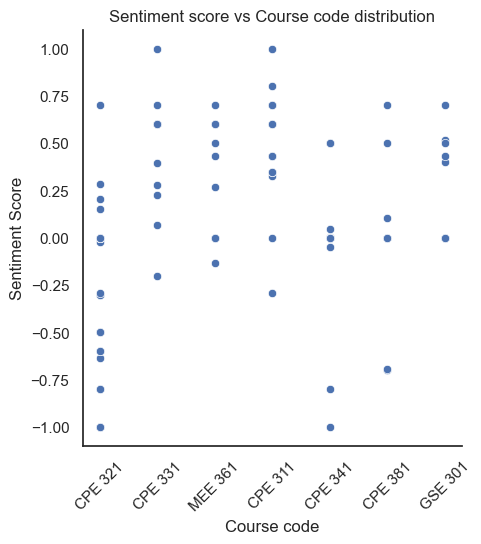

In [54]:
# Sentiment score Distribution by Course code
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
sns.relplot(data=df, x='Course Code',y = 'Sentiment_Score', color=color, kind='scatter')
plt.xlabel('Course code')
plt.ylabel('Sentiment Score')
plt.title('Sentiment score vs Course code distribution')
plt.xticks(rotation=45)
plt.show();

In [55]:
# correlation matrix of all variables in the data
correlation_matrix = df.corr()

plt.figure(figsize=[20, 6])
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=cmap, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation between variables in the dataset')

for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if i != j:
            text = '{:.2f}'.format(correlation_matrix.iloc[i, j])
            plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black')

colorbar = plt.gca().collections[0].colorbar
colorbar.set_ticks([-1, -0.5, 0, 0.5, 1])
colorbar.set_ticklabels(['Strong Negative', 'Negative', 'Neutral', 'Positive', 'Strong Positive'])

plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

ValueError: could not convert string to float: 'CPE 321'

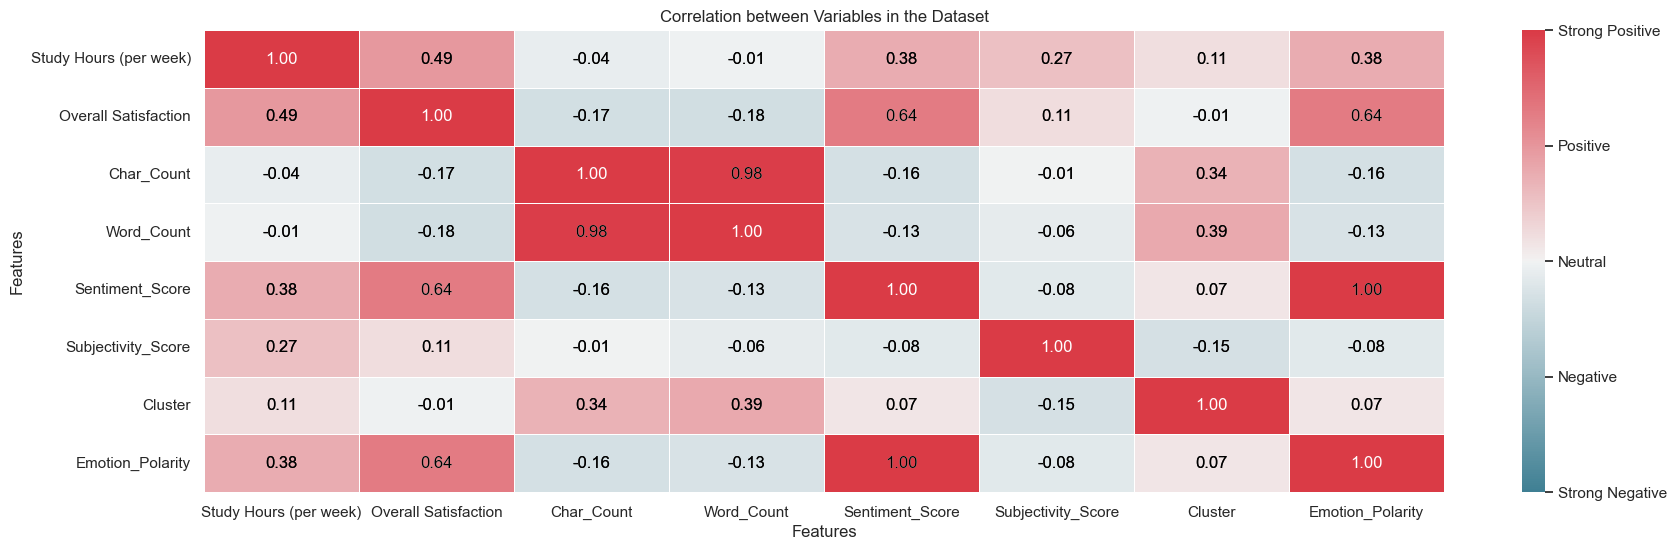

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your CSV file into a DataFrame
# df = pd.read_csv('your_feedback_file.csv')  # Uncomment and set your file path

# Select only numeric columns for the correlation matrix
numeric_df = df.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(20, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=cmap, vmin=-1, vmax=1, linewidths=0.5)

# Add title
plt.title('Correlation between Variables in the Dataset')

# Add annotations manually
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if i != j:
            text = '{:.2f}'.format(correlation_matrix.iloc[i, j])
            heatmap.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black')

# Customize the color bar
colorbar = heatmap.collections[0].colorbar
colorbar.set_ticks([-1, -0.5, 0, 0.5, 1])
colorbar.set_ticklabels(['Strong Negative', 'Negative', 'Neutral', 'Positive', 'Strong Positive'])

# Set axis labels
plt.xlabel('Features')
plt.ylabel('Features')

# Display the plot
plt.show()


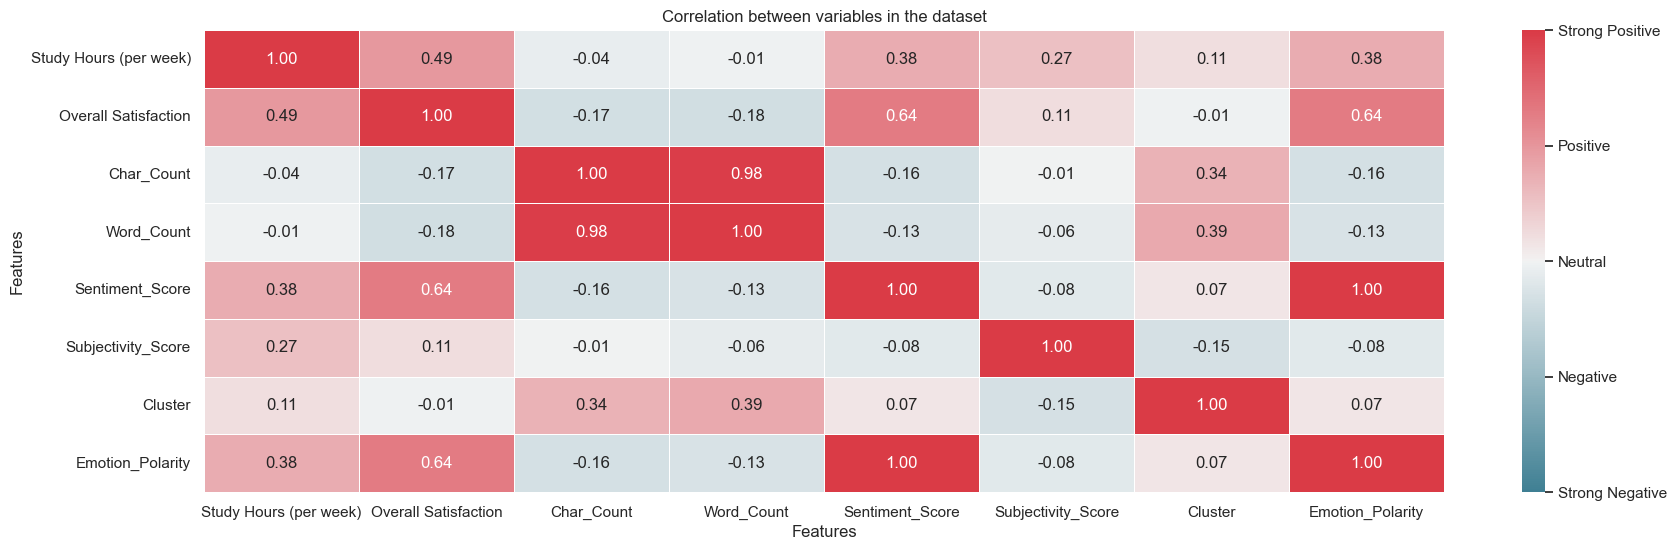

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that 'df' only contains numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot correlation matrix
plt.figure(figsize=[20, 6])
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=cmap, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation between variables in the dataset')

# Remove manual annotation as sns.heatmap with annot=True already adds annotations
# for i in range(correlation_matrix.shape[0]):
#     for j in range(correlation_matrix.shape[1]):
#         if i != j:
#             text = '{:.2f}'.format(correlation_matrix.iloc[i, j])
#             plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black')

# Adjust colorbar ticks and labels
colorbar = plt.gca().collections[0].colorbar
colorbar.set_ticks([-1, -0.5, 0, 0.5, 1])
colorbar.set_ticklabels(['Strong Negative', 'Negative', 'Neutral', 'Positive', 'Strong Positive'])

plt.xlabel('Features')
plt.ylabel('Features')
plt.show()


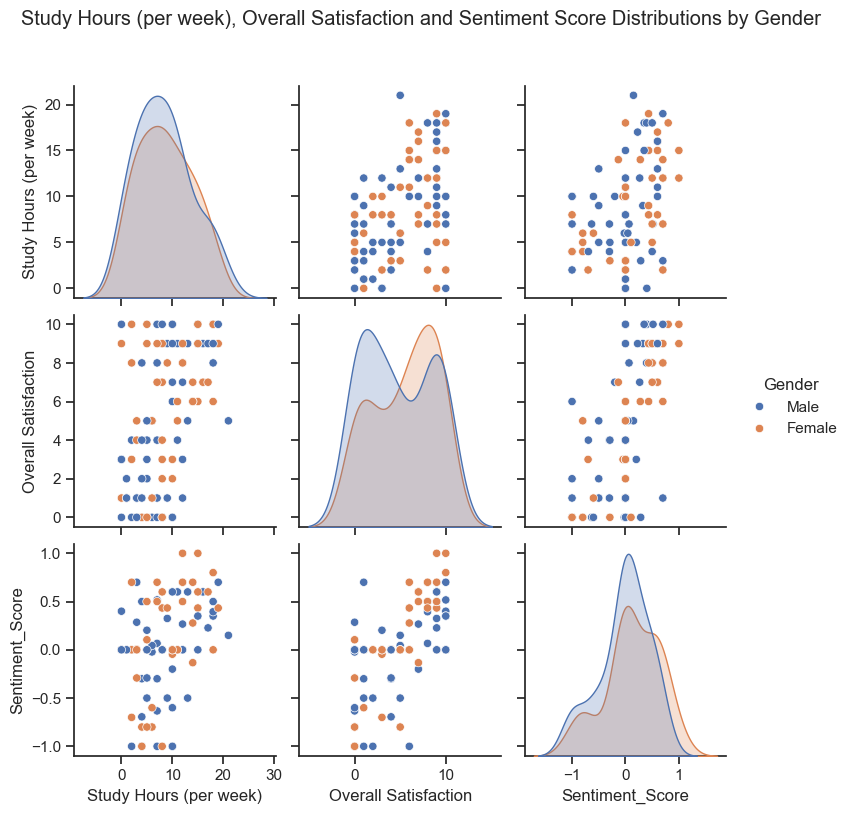

In [64]:
sns.set(style='ticks')
sns.pairplot(data=df, vars=['Study Hours (per week)', 'Overall Satisfaction', 
                            'Sentiment_Score'], hue='Gender', markers='o')
plt.suptitle('Study Hours (per week), Overall Satisfaction and Sentiment Score Distributions by Gender',
             y=1.08)
plt.show();

In [65]:
X = df['Processed_Feedback']
y = df['Sentiment_Label']

print(X.shape, y.shape)

#(100,) (100,)

le = LabelEncoder()
y_encoded = le.fit_transform(y)
print('Encoded Target Labels:')
print(y_encoded, '\n')

# get mapping for each label
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print('Label Mappings:')
print(le_name_mapping)

(100,) (100,)
Encoded Target Labels:
[1 1 0 1 1 1 2 1 1 2 1 0 1 0 1 2 0 0 0 1 1 2 0 0 1 1 2 1 1 0 2 1 1 1 1 2 0
 2 0 1 2 1 0 2 2 0 2 0 1 0 1 0 1 0 2 1 2 1 1 1 1 2 0 2 1 1 1 2 2 0 2 1 1 2
 2 0 2 1 0 2 2 0 2 2 0 2 1 1 1 2 2 1 2 1 2 2 0 1 2 2] 

Label Mappings:
{'Negative': 0, 'Neutral': 1, 'Positive': 2}


In [66]:
# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Preprocessor
preprocessor = Pipeline([
    ('bow', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
])

# XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(
    learning_rate=0.1,
    max_depth=6,
    n_estimators=80,
    use_label_encoder=False,
    objective='multi:softmax',
    eval_metric='merror',
    num_class=3
)

# Pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb_classifier),
])

# Hyperparameter Tuning
param_grid = {
    'model__learning_rate': [0.1, 0.01, 0.001],
    'model__max_depth': [6, 8, 10],
    'model__n_estimators': [80, 100, 120],
}
grid_search = GridSearchCV(pipe, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print('Best parameters:', best_params)

# Fit and Evaluate on Testing Set
pipe.set_params(**best_params)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('Testing Accuracy:', acc)

NameError: name 'GridSearchCV' is not defined

In [71]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score
import xgboost as xgb

# Sample data (replace this with your actual data)
# df = pd.read_csv('your_data.csv')
X = df['Processed_Feedback']
y = df['Sentiment_Label']

# Example of label encoding for target variable (assuming it is categorical)
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# y_encoded = le.fit_transform(y)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Preprocessor
preprocessor = Pipeline([
    ('bow', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
])

# XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(
    learning_rate=0.1,
    max_depth=6,
    n_estimators=80,
    use_label_encoder=False,
    objective='multi:softmax',
    eval_metric='merror',
    num_class=3
)

# Pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb_classifier),
])

# Hyperparameter Tuning
param_grid = {
    'model__learning_rate': [0.1, 0.01, 0.001],
    'model__max_depth': [6, 8, 10],
    'model__n_estimators': [80, 100, 120],
}

grid_search = GridSearchCV(pipe, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print('Best parameters:', best_params)

# Update pipeline with the best parameters and fit on training data
pipe.set_params(**grid_search.best_estimator_.get_params())
pipe.fit(X_train, y_train)

# Evaluate on testing set
y_pred = pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('Testing Accuracy:', acc)


Best parameters: {'model__learning_rate': 0.01, 'model__max_depth': 6, 'model__n_estimators': 80}
Testing Accuracy: 0.75


In [73]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score
import xgboost as xgb

# Example data (replace this with your actual data)
# df = pd.read_csv('your_data.csv')
# X = df['text_column']
# y = df['target_column']

# Example of label encoding for target variable (assuming it is categorical)
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# y_encoded = le.fit_transform(y)

# Preprocessor
preprocessor = Pipeline([
    ('bow', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
])

# XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(
    learning_rate=0.1,
    max_depth=6,
    n_estimators=80,
    use_label_encoder=False,
    objective='multi:softmax',
    eval_metric='merror',
    num_class=3
)

# Pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb_classifier),
])

# Hyperparameter Tuning with Cross-Validation
param_grid = {
    'model__learning_rate': [0.1, 0.01, 0.001],
    'model__max_depth': [6, 8, 10],
    'model__n_estimators': [80, 100, 120],
}

grid_search = GridSearchCV(pipe, param_grid, cv=5)
grid_search.fit(X, y_encoded)
best_params = grid_search.best_params_
print('Best parameters:', best_params)

# Fit and Evaluate using Cross-Validation
pipe.set_params(**grid_search.best_estimator_.get_params())
cv_scores = cross_val_score(pipe, X, y_encoded, cv=5)
mean_cv_score = cv_scores.mean()
print('Cross-validation accuracy:', mean_cv_score)

# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Fit the pipeline on the training data with best params
pipe.fit(X_train, y_train)

# Evaluate on testing set
y_pred = pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('Testing Accuracy:', acc)


Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 80}
Cross-validation accuracy: 0.6399999999999999
Testing Accuracy: 0.65


In [77]:
X

0     man fast teachinghe clearly doesnt know teach ...
1                           class dry really put effort
2        course shit threat brainthe teaching mode poor
3                                  try didnt teach well
4                              ogbeni sef know e dae go
                            ...                        
95                                          easy wahala
96             terrible way teaching idontcare attitude
97                                          like coding
98                  practical hard top unit course haba
99                            right way teach mr akanni
Name: Processed_Feedback, Length: 100, dtype: object

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\priya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\priya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\priya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\priya\AppData\Roaming\nltk_data...


True

In [80]:
X = df['Processed_Feedback']
y = df['Sentiment_Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [82]:
# Train Logistic Regression model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Predict on test set
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    Negative       1.00      0.50      0.67         4
     Neutral       0.70      0.88      0.78         8
    Positive       0.75      0.75      0.75         8

    accuracy                           0.75        20
   macro avg       0.82      0.71      0.73        20
weighted avg       0.78      0.75      0.74        20



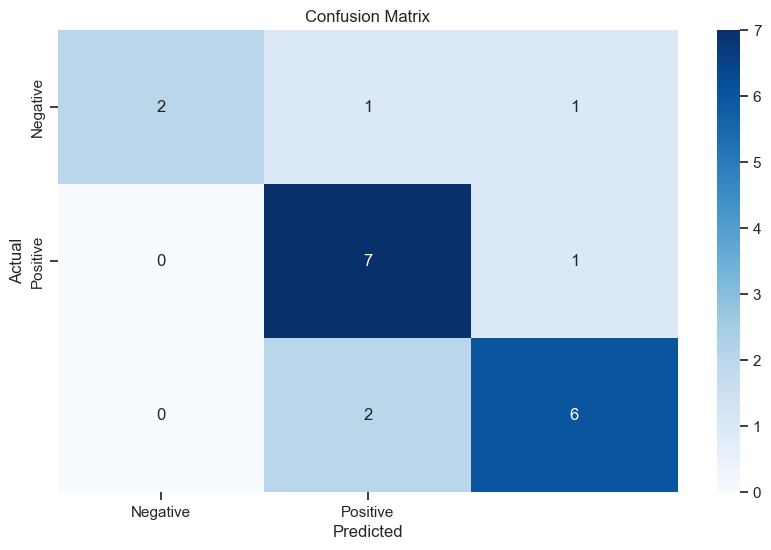

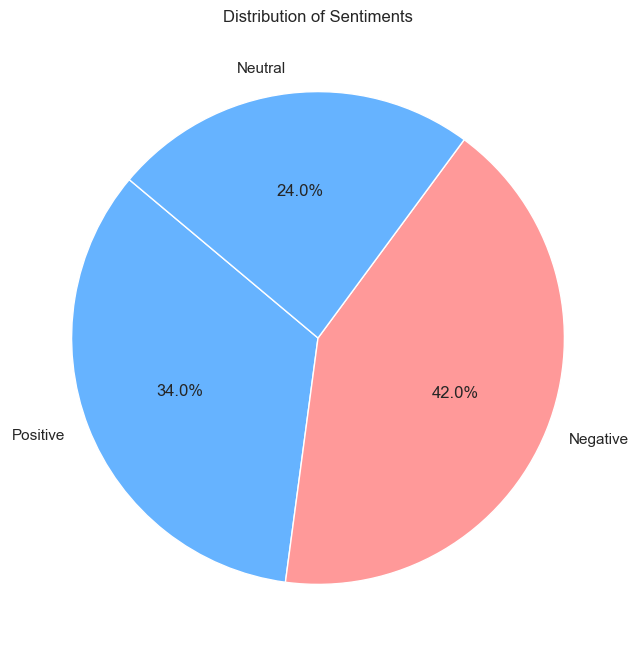

In [85]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Pie Chart of Sentiments
sentiment_counts = df['Sentiment_Label'].value_counts()
labels = ['Positive', 'Negative','Neutral']
sizes = [sentiment_counts[1], sentiment_counts[0],sentiment_counts[2]]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#ff9999'])
plt.title('Distribution of Sentiments')
plt.show()


Accuracy: 0.75
Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.50      0.67         4
     Neutral       0.70      0.88      0.78         8
    Positive       0.75      0.75      0.75         8

    accuracy                           0.75        20
   macro avg       0.82      0.71      0.73        20
weighted avg       0.78      0.75      0.74        20



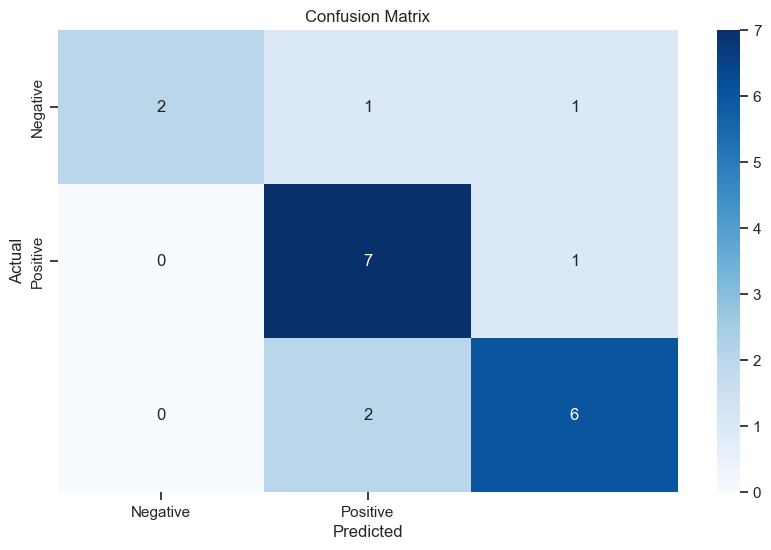

In [86]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()